# Topic Modeling using Latent Dirichlet Allocation (LDA)

| Key              | Value                                                                                                                                                                                                                                                                                              |
|:-----------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Course Codes** | BBT 4206, BFS 4102                                                                                                                                                                                                                                                                                 |
| **Course Names** | BBT 4206: Business Intelligence II (Week 10-12 of 13) and <br/>BFS 4102: Advanced Business Data Analytics (Week 10-12 of 13)                                                                                                                                                                       |
| **Semester**     | August to November 2025                                                                                                                                                                                                                                                                            |
| **Lecturer**     | Allan Omondi                                                                                                                                                                                                                                                                                       |
| **Contact**      | aomondi@strathmore.edu                                                                                                                                                                                                                                                                             |
| **Note**         | The lecture contains both theory and practice.<br/>This notebook forms part of the practice.<br/>It is intended for educational purpose only.<br/>Recommended citation: [BibTex](https://raw.githubusercontent.com/course-files/NaturalLanguageProcessing/refs/heads/main/RecommendedCitation.bib) |

**Business context**: A business has set a strategic objective *to increase the monthly average customer rating to 3.8/5 by the end of the current financial year*. The business tracks two Key Performance Indicators (KPIs) from the customer perspective:

1. **Lagging KPI**: Monthly average customer rating
2. **Leading KPI**: List of key themes in customer reviews. This will then be followed up with sentiment analysis to identify how customers feel about these themes.

The business wants to leverage Natural Language Processing (NLP) to identify the key themes present in customer reviews. This will enable it to better understand the qualitative aspects of customer feedback. By applying topic modeling techniques to historical review data, the business can identify what customers are talking about (the topics), which can then be followed up with sentiment analysis to identify how customers feel about these topics. That is, whether their comments are positive, negative, or neutral.

**Dataset:** The original dataset by **Ott and Arvidsson (2023)** consists of 878,561 reviews (1.3GB) from 4,333 hotels crawled from **TripAdvisor ([https://www.tripadvisor.com/](https://www.tripadvisor.com/))**.
Points to note:
- Some reviews are written in French. Source: [https://www.cs.cmu.edu/~jiweil/html/hotel-review.html](https://www.cs.cmu.edu/~jiweil/html/hotel-review.html) or [https://www.kaggle.com/datasets/joebeachcapital/hotel-reviews](https://www.kaggle.com/datasets/joebeachcapital/hotel-reviews).
- We use a scaled-down version of the dataset (a sample) that contains 50,000 reviews for the sake of performance and efficiency in a lab setting for educational purposes.

| Feature            | Description                                                                           |
|--------------------|---------------------------------------------------------------------------------------|
| `date`             | Indicates the date when the review was written                                        |
| `offering_id`      | Indicates the ID of the hotel that the customer stayed in                             |
| `date_stayed`      | Indicates the date when the customer stayed at the hotel                              |
| `text`             | Contains the review text                                                              |
| `rating_overall`   | Overall rating given by the customer (1 to 5 stars; 1 is the worst and 5 is the best) |
| `is_english`       | Indicates whether the review is written in English (`True`) or not (`False`)          |
| `author_username`  | Indicates the username of the customer who wrote the review                           |
| `author_location`  | Indicates the location of the customer who wrote the review                           |

## Step 1: Import the necessary libraries

**Purpose**: This chunk imports all the necessary libraries for data analysis, machine learning, and visualization.

1. **For File and system operations [urllib3](https://urllib3.readthedocs.io/en/stable/)**
    - `urllib.request` is used for opening and downloading data from URLs.
    - `os` provides functions for interacting with the operating system, such as file and directory management.
    - The `import sys` statement allows access to Python's system-specific parameters and functions, such as command-line arguments and the interpreter environment.
    - `sys` is imported to check if the code is running in Google Colab or not, which can affect how files are downloaded or saved.

2. **For data manipulation - [pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html) and [numpy](https://numpy.org/doc/stable/index.html):**
    - `pandas as pd`: For loading the dataset, creating and managing DataFrames, data manipulation and analysis using DataFrames
    - `numpy as np`: For numerical operations and array manipulations

3. **For text preprocessing - [re](https://docs.python.org/3/library/re.html)**
    - `re`: For regular expression operations to clean and preprocess text data

4. **For topic modeling - [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html)**
    - `CountVectorizer` converts a collection of text documents into a matrix of token counts for machine learning.
    - `LatentDirichletAllocation` is used for discovering abstract topics within a collection of text documents through topic modeling.

5. **For data visualization - [matplotlib](https://matplotlib.org/stable/gallery/index.html)**
    - `matplotlib.pyplot as plt`: For basic plotting functionality

6. **For formatting of display text**
    - `textwrap` is used to format and wrap text for improved readability in output.

7. **For mathematical operations**
    - `math` supplies mathematical functions like ceiling, floor, and trigonometric operations.

8. **For model persistence - [joblib](https://joblib.readthedocs.io/en/stable/)**
    - `joblib` is used for saving and loading Python objects, such as machine learning models, to and from disk.

In [1]:
# For File and system operations
import urllib.request
import os

# For data manipulation
import pandas as pd
import numpy as np

# For text preprocessing
import re

# For topic modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# For data visualization
import matplotlib.pyplot as plt

# For formatting of display text
import textwrap

# For mathematical operations
import math

# For model persistence
import joblib
import json

## Step 2: Load the data

**Purpose**: This chunk loads the dataset by checking if the dataset exists locally; if not, then it downloads it from the specified URL and saves it locally before loading it into a Pandas DataFrame.

- **Data Loading Parameters**
    - Uses `pd.read_csv()` with specific parameters:
        - `usecols`: Loads only the columns specified in `use_cols` for memory efficiency
        - `encoding='utf-8'`: Handles special characters in the dataset. This is suitable for most languages and special characters like ñ, €, ®. Other alternative encodings include:
        - `encoding='utf-16'`: Supports multilingual characters, uses 2 Bytes per character.
        - `encoding='utf-32'`: Like utf-16 but uses 4 Bytes per character, suitable for full Unicode range.
        - `encoding='latin-1'`: Handles Western European characters such as ñ, ß, € without throwing decode errors.
        - `encoding='big5'`: Traditional Chinese encoding used in Taiwan and Hong Kong.
        - `encoding='shift_jis'`: Japanese character encoding used on Windows.
        - You can try different encodings if you encounter the `UnicodeDecodeError` while reading a file. This is useful in cases where the business has branches across different countries and the dataset contains characters from multiple languages.
        - `nrows=200000`: Limits the number of rows loaded to 200,000. This can be reduced or increased based on the available memory and the size of the dataset.
    - The data is then stored in a `Pandas` DataFrame for further analysis
    - This selective loading approach helps manage memory usage and focuses the analysis on the relevant features for the design of the model.
- `iloc` is used for integer-location-based indexing, so `customer_reviews_data['text'].iloc[0]` retrieves the first row's review text.
- The code then takes the first 100 characters of that review and appends "..." to indicate truncation.

In [2]:
dataset_path = './data/processed_scaled_down_reviews.csv'
url = 'https://github.com/course-files/SentimentAnalysis/raw/refs/heads/main/data/processed_scaled_down_reviews.csv'

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    if not os.path.exists('./data'):
        os.makedirs('./data')
    urllib.request.urlretrieve(url, dataset_path)
    print("✅ Dataset downloaded")
else:
    print("✅ Dataset already exists locally")

customer_reviews_data = pd.read_csv(dataset_path, encoding='utf-8')
print(f"\nLoaded: {len(customer_reviews_data)} reviews")
print("Sample review:")
print(customer_reviews_data['text'].iloc[0][:100] + "...")

✅ Dataset already exists locally

Loaded: 50000 reviews
Sample review:
Being from a small town in Tennessee, I was very unsure of what to expect from the large city hotel....


## Step 3: Text Preprocessing

- **Purpose**: This chunk checks if the reviews are in English and cleans the text data.

Latent Dirichlet Allocation (LDA) can work with text collections that include multiple languages, but there are important considerations to ensure meaningful and interpretable results.
- **Fundamental Principle**: LDA is an unsupervised probabilistic model that discovers latent topics based on word co-occurrence patterns within documents. It does not inherently know what language the words belong to; it simply treats all tokens as part of a single vocabulary.

- **Challenges with Multiple Languages**:
  - **Separate vocabularies**: Words from different languages typically do not overlap, which can lead to the model identifying topics that correspond more to the language itself rather than to thematic content. For example, one topic might become dominated by English words, while another becomes dominated by Swahili words.
  - **Stop words**: Each language has its own set of stop words (e.g., “the”, “and”, “is” in English; “na”, “kwa”, “ni” in Swahili). These need to be removed appropriately; otherwise, they can distort the topic distributions.
  - **Semantic coherence**: The quality and interpretability of topics can be reduced because the same concept expressed in different languages might appear in different topics rather than being grouped together.

- **Possible Solutions**:
  - **Preprocessing**: Identify the language of each document or sentence and preprocess separately (including language-specific stop word removal, lemmatization, etc.).
  - **Separate Models**: Train separate LDA models **for each language** and later map or align topics across languages.
  - **Translation**: Translate all documents into a single language before applying LDA.
  - **Multilingual embeddings**: Use multilingual word embeddings to bring words from different languages into a shared vector space before applying topic modeling (this typically involves more advanced models than standard LDA).

- **Advanced Approaches**: There are **multilingual topic models** specifically designed to handle documents in multiple languages by aligning topics across languages, e.g.:
  - **Multilingual LDA (MLDA)**
  - **Polylingual Topic Model (PLTM)**

---

- `reset_index(drop=True)`
- An index in a DataFrame uniquely identifies each row, allowing for efficient data selection, alignment, and retrieval. It acts as a label for rows, similar to row numbers, and is used for operations like filtering, joining, and resetting the order after filtering or modifying data.
- `reset_index(drop=True)` resets the DataFrame’s index to a default integer index (0, 1, 2, ...), and with `drop=True`, it discards the old index instead of adding it as a new column. This is useful after filtering rows to ensure that the index remains sequential and clean.
- A DataFrame in `pandas` automatically has an index (default: integer starting from 0). To create or set a custom index, use the set_index() method, e.g., `customer_reviews_data = customer_reviews_data.set_index('review_id')`

---
- Note that additional filtering can be done at this point. For example, if the business wants to focus on reviews for a particular hotel or a specific time period, you can filter the DataFrame accordingly.
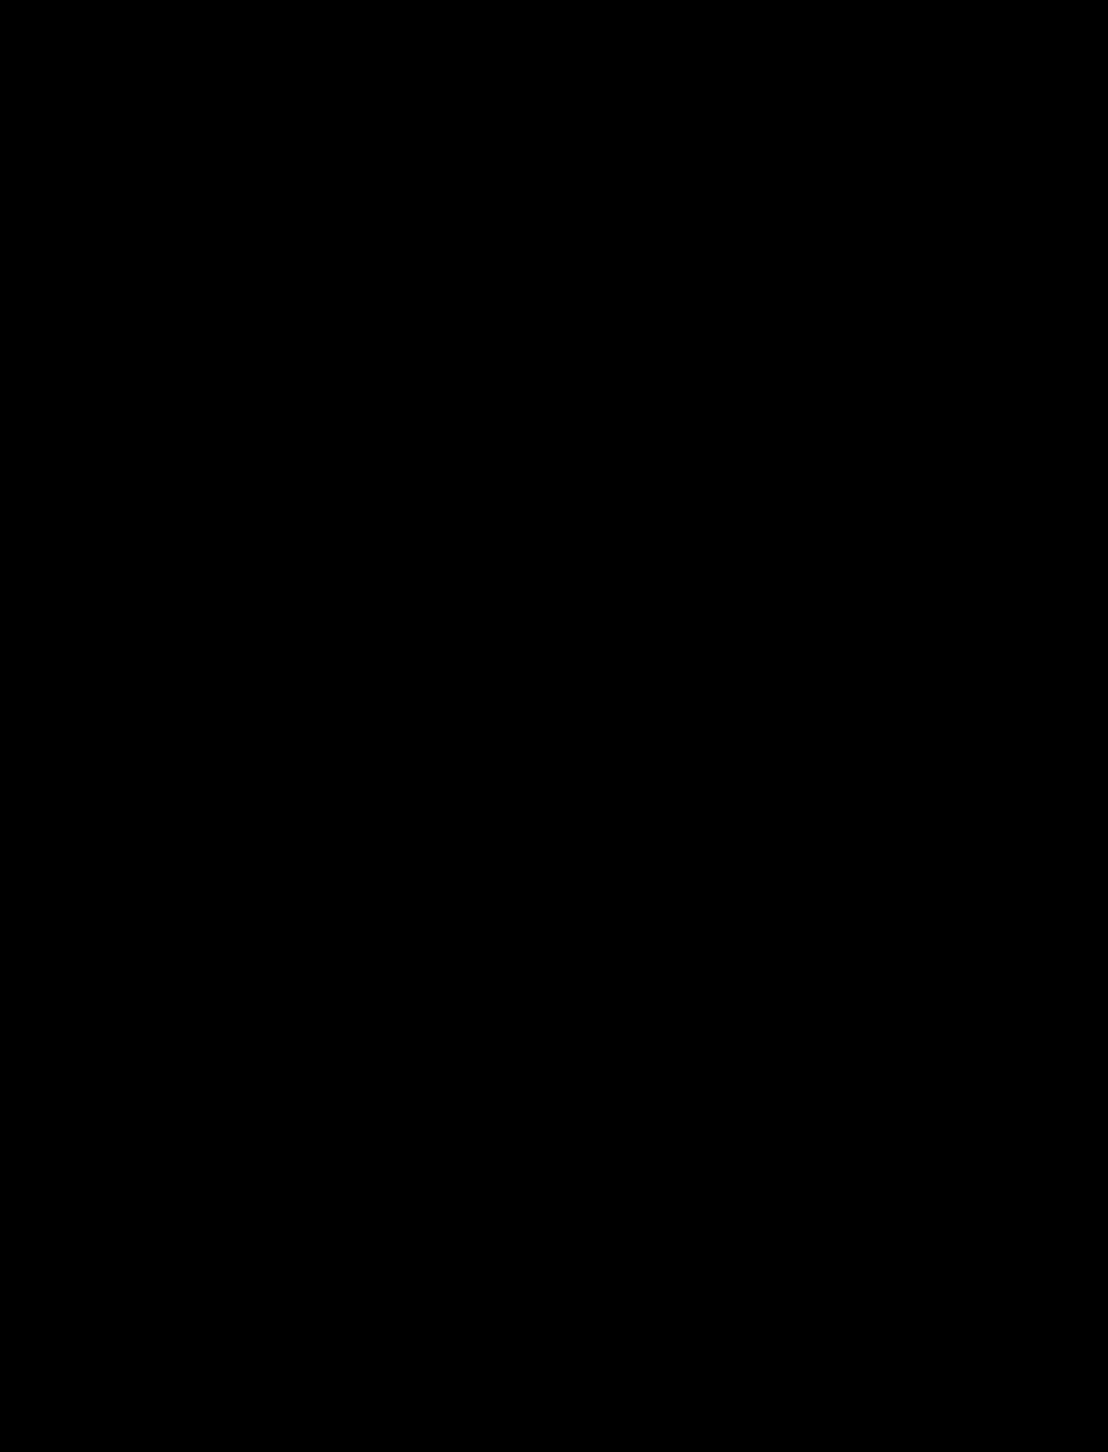
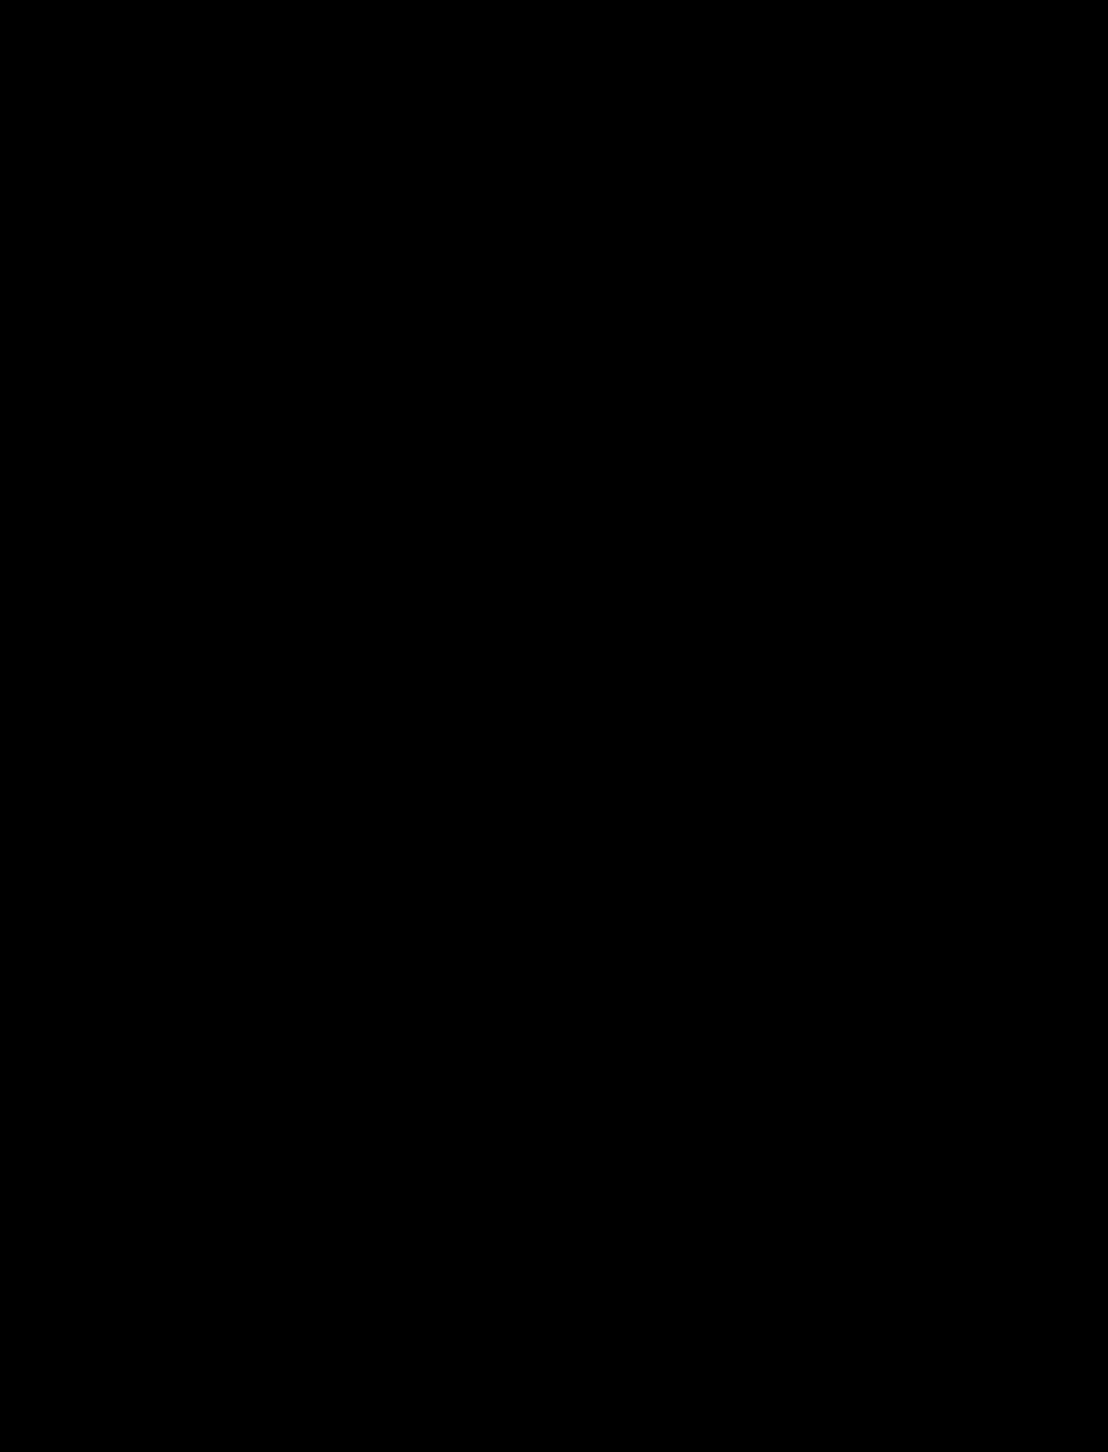
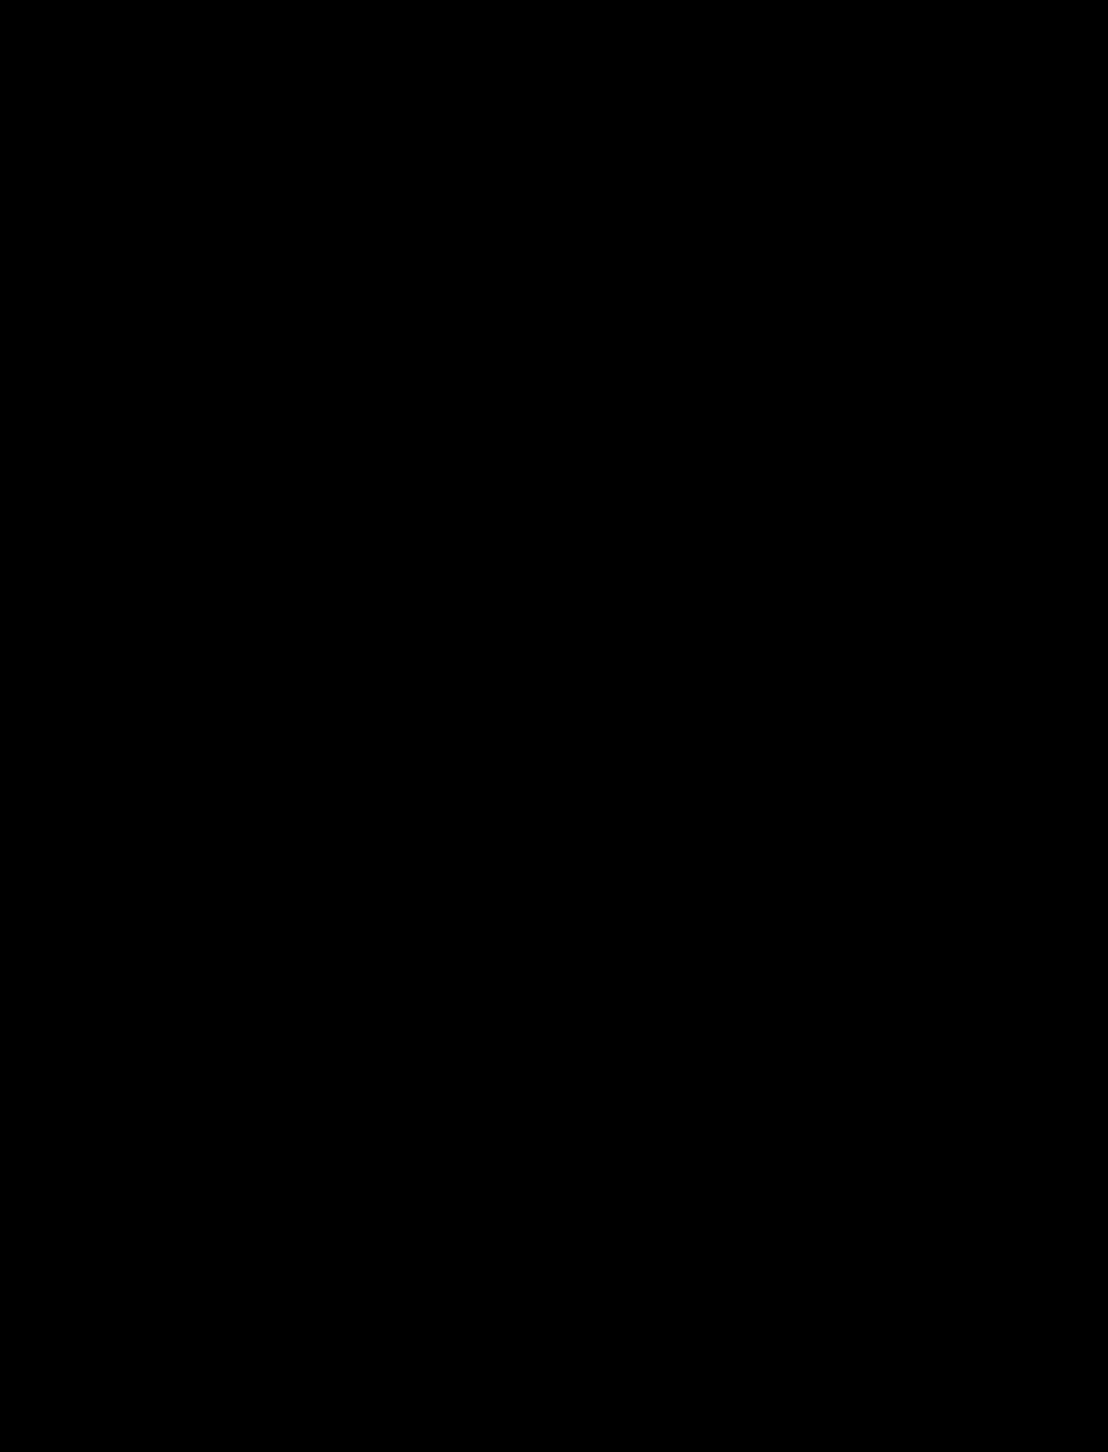

In [3]:
customer_reviews_data = customer_reviews_data[customer_reviews_data['is_english'] == True].reset_index(drop=True)
print(f"Filtered: The DataFrame now contains {len(customer_reviews_data)} reviews written using the English language")

Filtered: The DataFrame now contains 44007 reviews written using the English language


- **Purpose**: This chunk cleans the text data by removing non-alphabet characters and collapsing multiple spaces into a single space.
- The `clean_text` function uses regular expressions to:
  - Remove any character that is not a letter or space.
  - Convert the text to lowercase.
  - Collapse multiple spaces into a single space and strip leading/trailing spaces.
    - This is important for ensuring that the text is in a consistent format for further analysis.

- **Regular Expressions**: Regular expressions are a powerful tool for matching and extracting patterns from text. They are used to perform complex text processing tasks like filtering, searching, and replacing.
  - A tutorial on regular expressions: https://regexone.com/
  - To test your regular expression: https://regexr.com/

In [4]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    text = re.sub(r'\s+', ' ', text).strip()
    return text

customer_reviews_data['clean_text'] = customer_reviews_data['text'].apply(clean_text)

In [5]:
display(customer_reviews_data[['text', 'clean_text', 'rating_overall']].head())

,text,clean_text,rating_overall
0,"Being from a small town in Tennessee, I was ve...",being from a small town in tennessee i was ver...,5.0
1,I stayed at this courtyard for 2 nights . Ever...,i stayed at this courtyard for nights everythi...,4.0
2,Even in Boston for $180 plus taxes per night y...,even in boston for plus taxes per night you mi...,3.0
3,This hotel is a great old building (formerly t...,this hotel is a great old building formerly th...,2.0
4,"The Good~room was larger than expected, free i...",the goodroom was larger than expected free int...,2.0


## Step 4: Create the Document-Term Matrix (DTM)

- **Purpose**: This chunk converts the cleaned text into a document-term matrix (DTM) using the `CountVectorizer` from scikit-learn.

- A DTM is a sparse matrix where each row represents a document (review), and each column represents a unique word (feature) from the corpus.
- `max_features=1000` limits the vocabulary to the 1000 most frequent words, which helps reduce dimensionality and noise.
- `stop_words='english'` removes common English language words (like "the", "is", etc.) that do not contribute much to the meaning of the text.
- `max_df=0.95` ignores words that appear in more than 95% of the documents, as they are likely too common to be useful.
- `min_df=3` ignores words that appear in fewer than three (3) documents, as they are too rare to be significant.
- The resulting DTM is a sparse matrix where each row corresponds to a document and each column corresponds to a word in the vocabulary.
---
- The shape of the DTM is printed to confirm its dimensions, which should be (number of documents, number of features).
- The first 10 feature names (words) are printed to give an idea of the vocabulary used in the DTM.

- The DTM is a crucial step in text analysis, as it transforms unstructured text into a structured format that can be analyzed statistically.
- The DTM can be used for various tasks such as topic modeling, sentiment analysis, and text classification.
- The `CountVectorizer` is highly customizable, allowing for various preprocessing options such as tokenization, n-grams, and more.
- The DTM can be further processed or transformed using techniques like TF-IDF (Term Frequency-Inverse Document Frequency) to weigh the importance of words in the context of the entire corpus.

- The DTM can be saved to a file for later use or analysis, allowing for reproducibility and sharing of results.
- The DTM can be visualized using techniques like word clouds or heatmaps to gain insights into the most frequent words and their distributions across documents.
- The DTM can be used as input for machine learning algorithms, enabling tasks like clustering and classification on text data.

In [6]:
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=1000,
    stop_words='english'
)

doc_term_matrix = vectorizer.fit_transform(customer_reviews_data['clean_text'])
print(f"\n**The Document-Term Matrix has been created**\n")
print(f"Shape: {doc_term_matrix.shape} (documents x features)")
print("Sample features:", vectorizer.get_feature_names_out()[:10])


**The Document-Term Matrix has been created**

Shape: (44007, 1000) (documents x features)
Sample features: ['able' 'absolutely' 'ac' 'access' 'accommodating' 'accomodating'
 'actually' 'add' 'added' 'addition']


In [7]:
# Converts a "slice" of the DTM into a DataFrame for display
dtm_sample = pd.DataFrame(
    doc_term_matrix[:10, :20].toarray(),  # first 10 documents, first 20 terms
    columns=vectorizer.get_feature_names_out()[:20]
)
display(dtm_sample)

,able,absolutely,ac,access,accommodating,accomodating,actually,add,added,addition,additional,adequate,adults,advance,advantage,advice,afternoon,ago,air,airport
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Step 5: Design the Topic Model using the Latent Dirichlet Allocation (LDA) Algorithm

- **Purpose**: This chunk configures the Latent Dirichlet Allocation (LDA) model for topic modeling.
- LDA is a generative probabilistic model that assumes each document is a mixture of topics, and each topic is a mixture of words.
- `n_components=5` specifies the number of topics to discover in the dataset.
- `learning_method='online'` uses an online (incremental) learning algorithm, which is suitable for large datasets and allows the model to update incrementally.
- `random_state=53` sets a random seed for reproducibility, ensuring that the results can be replicated.
- `max_iter=9` limits the number of iterations for the model to converge. This can be adjusted based on the complexity of the dataset and the desired accuracy.
- `n_jobs=-1` allows the model to use all available CPU cores for parallel processing, speeding up the training process. The alternative is to set `n_jobs` to a specific positive integer (e.g., `n_jobs=1`), which limits the model to using only that number of CPU cores for parallel processing. For example, `n_jobs=1` uses only a single core.
- The `LatentDirichletAllocation` class from scikit-learn is used to create the LDA model.
- The model is then trained using the document-term matrix (`doc_term_matrix`), which contains the preprocessed text data.
- The `fit` method trains the LDA model on the document-term matrix, discovering the underlying topics in the text data.
- After fitting, the model can be used to infer topics for new documents or to analyze the distribution of topics across the dataset.
- The model can be evaluated using metrics like **perplexity**, which measures how well the model predicts the data. Lower perplexity indicates a better fit.
- The trained model can be saved for later use, allowing for efficient topic inference on new data without retraining.
- The LDA model can be used for various applications such as document clustering, topic discovery, and text summarization.
- The LDA model can be fine-tuned by adjusting hyperparameters like the number of topics, learning rate, and regularization parameters to improve topic coherence and interpretability.
- The LDA model can be extended to include additional features like bigrams or trigrams, which can capture more context and improve topic quality. By default, LDA uses unigrams (single words) as features, because `CountVectorizer` defaults to `ngram_range=(1, 1)`. To include bigrams or trigrams, you need to set `ngram_range=(1, 2)` or `ngram_range=(1, 3)` in `CountVectorizer` when you are creating the DTM.
- The LDA model can be combined with other techniques like sentiment analysis to gain deeper insights into customer feedback and opinions.

In [9]:
lda = LatentDirichletAllocation(
    n_components=5,
    learning_method='online',
    random_state=53,
    max_iter=9,
    n_jobs=-1
)

lda.fit(doc_term_matrix)
print("\nModel training complete")
print(f"Perplexity: {lda.perplexity(doc_term_matrix):.2f} (lower is better)")


Model training complete
Perplexity: 508.14 (lower is better)


## Step 6: Explore the Discovered Topics

- **Purpose**: This chunk retrieves and prints the top words for each topic discovered by the LDA model.
- `get_feature_names_out()` retrieves the feature names (words) from the `CountVectorizer` used to create the document-term matrix.
- `model.components_` contains the topic-word distributions, where each row corresponds to a topic and each column corresponds to a word in the vocabulary.
- `topic.argsort()[:-n_words-1:-1]` sorts the words in descending order of their importance to the topic and retrieves the indices of the top `n_words` words.
- `top_words = [provided_feature_names[i] for i in top_idx]` retrieves the actual words corresponding to the top indices.
- The function `print_topics` iterates through each topic, retrieves the top words, and prints them in a readable format.
---
- The topics are printed with their corresponding top words, providing insights into the themes present in the customer reviews.

In [10]:
identified_feature_names = vectorizer.get_feature_names_out()

def print_topics(model, provided_feature_names, n_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[:-n_words-1:-1]
        top_words = [provided_feature_names[i] for i in top_idx]
        print(f"Topic #{topic_idx+1}:")
        print("   " + " ".join(top_words))

print("Discovered Topics:")
print_topics(lda, identified_feature_names)

Discovered Topics:
Topic #1:
   hotel staff great stay room service stayed time rooms friendly
Topic #2:
   room hotel night desk did didnt stay just like rooms
Topic #3:
   hotel great location staff clean good rooms stay room nice
Topic #4:
   hotel parking san car night valet room worth street stay
Topic #5:
   room breakfast free nice coffee bed area bathroom airport good


## Step 7: Visualize the Topic Distribution

- **Purpose**: This chunk assigns the dominant topic to each document and visualizes the distribution of documents across topics.
- `lda.transform(doc_term_matrix)` computes the topic distribution for each document in the document-term matrix.
- `topic_results.argmax(axis=1)` retrieves the index of the topic with the highest probability for each document, effectively assigning the dominant topic to each document.
- A bar chart is created to visualize the distribution of documents across topics.
- `topic_counts = customer_reviews_data['dominant_topic'].value_counts().sort_index()` counts the number of documents assigned to each topic and sorts them by topic ID
- `plot(kind='bar', color='skyblue', edgecolor='black')` creates a bar chart with specified colors and edge styles

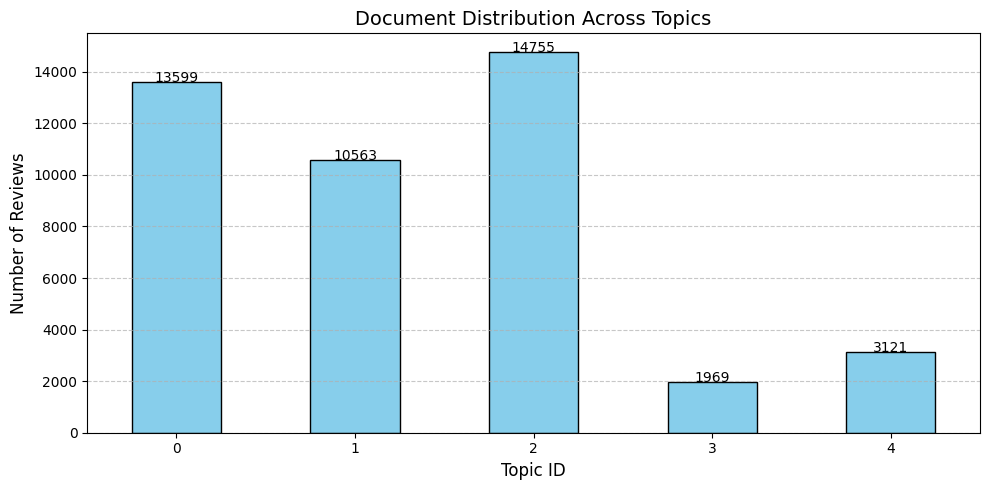

In [11]:
# Assign the dominant topic to each document
topic_results = lda.transform(doc_term_matrix)
customer_reviews_data['dominant_topic'] = topic_results.argmax(axis=1)
customer_reviews_data['topic_probability'] = topic_results.max(axis=1)

# Plot document distribution across topics
plt.figure(figsize=(10, 5))
topic_counts = customer_reviews_data['dominant_topic'].value_counts().sort_index()
topic_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Document Distribution Across Topics", fontsize=14)
plt.xlabel("Topic ID", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add counts on bars
for i, count in enumerate(topic_counts):
    plt.text(i, count+5, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## Step 8: Visualize the top words in each topic

- **Purpose**: This chunk visualizes the top words in each topic using horizontal bar charts.
- `n_topics = model.n_components` retrieves the number of topics in the LDA model.
- `n_cols = 3` and `n_rows = math.ceil(n_topics / n_cols)` determine the layout of the subplots, with three (3) columns and enough rows to accommodate all topics.
- `fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 5 * n_rows))` creates a grid of subplots for visualizing the top words in each topic.
- The loop iterates through each topic, retrieves the top words and their weights, and creates a horizontal bar chart for each topic.
- `ax.barh(y_pos, weights, color='skyblue', height=0.7, edgecolor='black')` creates a horizontal bar chart for the top words in the topic.
- `ax.set_yticks(y_pos)` and `ax.set_yticklabels(top_words)` set the y-axis ticks and labels to the top words.
- `ax.invert_yaxis()` inverts the y-axis to display the top word at the top of the chart.
- `ax.set_title(f"Topic {idx+1}", fontsize=12)` sets the title for each subplot.
- `ax.set_xlabel("Weight", fontsize=10)` sets the x-axis label for each subplot.
- `ax.text(v + 0.01, i, f"{v:.2f}", color='black', fontsize=9)` adds text annotations to the bars showing the weight of each word.
- `plt.suptitle("Top Words per Topic", fontsize=16)` sets a main title for the entire figure.
- `plt.tight_layout(rect=[0, 0, 1, 0.95])` adjusts the layout to prevent overlap and ensure that the main title is visible.
- The function `plot_topic_words` is defined to encapsulate this visualization logic, making it reusable for different models or datasets.
- This visualization helps in understanding the key themes represented by each topic and the most significant words associated with them.
- The horizontal bar charts provide a clear and intuitive way to compare the importance of different words within each topic.

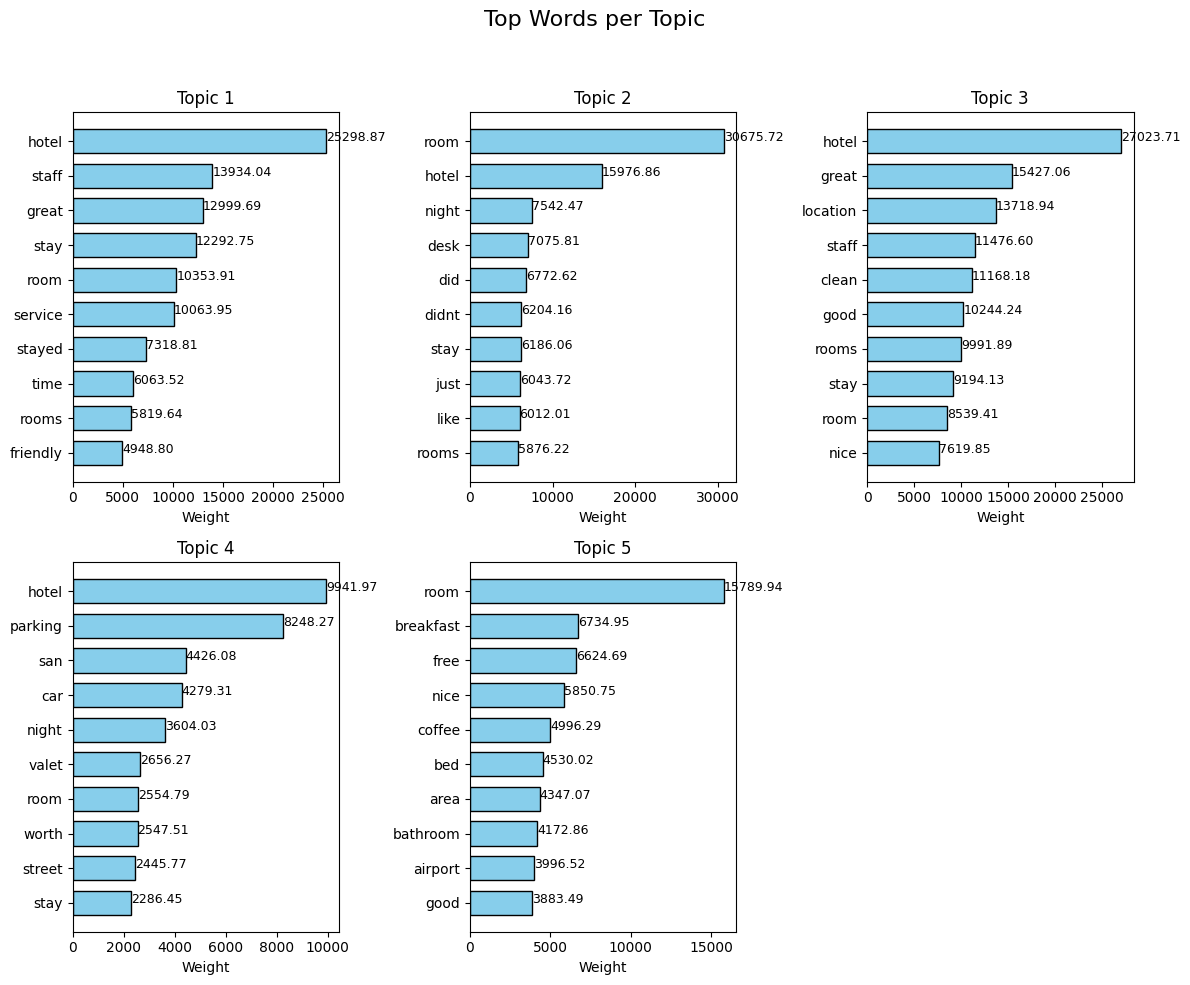

In [12]:
def plot_topic_words(model, identified_feature_names, n_words=10):
    n_topics = model.n_components
    n_cols = 3
    n_rows = math.ceil(n_topics / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 5 * n_rows))
    axes = axes.flatten()  # Flatten in case of a single row

    for idx in range(n_topics):
        ax = axes[idx]
        topic = model.components_[idx]
        top_idx = topic.argsort()[:-n_words-1:-1]
        top_words = [identified_feature_names[i] for i in top_idx]
        weights = topic[top_idx]

        y_pos = np.arange(len(top_words))
        ax.barh(y_pos, weights, color='skyblue', height=0.7, edgecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_words)
        ax.invert_yaxis()
        ax.set_title(f"Topic {idx+1}", fontsize=12)
        ax.set_xlabel("Weight", fontsize=10)
        for i, v in enumerate(weights):
            ax.text(v + 0.01, i, f"{v:.2f}", color='black', fontsize=9)

    # Hide unused subplots
    for j in range(n_topics, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Top Words per Topic", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_topic_words(lda, identified_feature_names)

## Step 9: Qualitative Analysis: Review Samples

- **Purpose**: This chunk shows representative reviews for each topic, providing qualitative insights into the themes identified by the LDA model.
- The function `show_representative_reviews` takes a topic ID and the number of reviews to display as parameters.
- `topic_docs = customer_reviews_data[customer_reviews_data['dominant_topic'] == topic_id]` filters the DataFrame to get all reviews associated with the specified topic.
- `top_docs = topic_docs.iloc[topic_results[topic_docs.index, topic_id].argsort()[-n_reviews:]]` retrieves the reviews with the highest topic probability for the specified topic.
- `get_topic_keywords` retrieves the top keywords for the specified topic using the LDA model and feature names.
- The function prints the topic ID, keywords, and representative reviews in a formatted manner.
- `textwrap.fill(row['text'], width=80)` formats the review text to a specified width for better readability.
- The function also iterates through the top reviews and prints them along with their ratings.
- This qualitative analysis helps in understanding the context and sentiment behind the topics identified by the LDA model.
- The representative reviews provide concrete examples of customer feedback related to each topic, allowing for deeper insights into customer opinions and experiences. The next step is to interpret and label the topics based on the words and sample reviews, which will provide a clearer understanding of what each topic represents.
- This analysis can inform business decisions, such as improving services, addressing customer concerns, or enhancing marketing strategies.
---
- Note that the output showing the representative reviews can also be fed to an LLM (Large Language Model) to label the topics.

In [13]:
def show_representative_reviews(topic_id, n_reviews=3):
    topic_docs = customer_reviews_data[customer_reviews_data['dominant_topic'] == topic_id]

    top_docs = topic_docs.iloc[topic_results[topic_docs.index, topic_id].argsort()[-n_reviews:]]

    print(f"\n{'='*60}")
    print(f"Representative Reviews for Topic #{topic_id+1}")
    print(f"Key words: {', '.join(get_topic_keywords(lda, identified_feature_names, topic_id))}")
    print('='*60)

    for i, (_, row) in enumerate(top_docs.iterrows()):
        print(f"\nReview #{i+1} (Rating: {row['rating_overall']}/5):")
        print(textwrap.fill(row['text'], width=80))
        print('-'*80)

def get_topic_keywords(model, identified_feature_names, topic_id, n_words=5):
    topic = model.components_[topic_id]
    top_idx = topic.argsort()[:-n_words-1:-1]
    return [identified_feature_names[i] for i in top_idx]

for topic_id in range(5):
    show_representative_reviews(topic_id)


Representative Reviews for Topic #1
Key words: hotel, staff, great, stay, room

Review #1 (Rating: 5.0/5):
Just returned from a 5 day stay at the Omni Chicago. I have travelled
extensively and have stayed in many different hotels, world-wide. I can't say
enough about the warm welcome, friendly staff and excellent service that I and
my friends received at the Omni. Deserving a special mention is the Head
Concierge, Amiri, who took care of us and all our requests (including a very
challenging one with respect to Oprah tickets!). He and his colleague, Marcus,
were not only efficient and knowledgeable, they were friendly and truly went the
extra mile to see that we enjoyed our stay. What we most appreciated about this
hotel is that the staff genuinely seem to enjoy their work - we never got the
impression that they were being pleasant because they have to. Housekeeping was
the best and fastest I've experienced, the staff at the entrance always welcomed
us back and asked if we needed anyth

## Step 10: Interpret and Label Topics with a Human-In-The-Loop Approach

- **Purpose**: This chunk provides suggested labels for the topics based on the top words and sample reviews.
- The `topic_labels` dictionary maps each topic ID to a human-readable label that summarizes the theme of the topic.
- The labels are based on the top words associated with each topic and the representative reviews displayed in the previous step.
- The labels are designed to capture the essence of what each topic represents, making it easier to interpret the results of the topic modeling.
- The labels can be used to communicate the findings to stakeholders, such as business managers or marketing teams, who may not be concerned with the technical details of topic modeling.
- The next step can involve sentiment analysis to understand how customers feel about the topics identified, which can further inform business decisions and strategies.

In [14]:
# Label the topics based on the words, sample reviews, and overall rating
topic_labels = {
    0: "Exceptional Guest Experience and Service Quality",
    1: "Negative Service Experiences and Front Desk Issues",
    2: "Great Location, Cleanliness, and Friendly Staff",
    3: "Value for Money and Convenient City Location",
    4: "Comfort and Practical Amenities for Short Stays"
}

print("\n**Suggested Topic Labels**")
for idx, label in topic_labels.items():
    print(f"Topic {idx+1}: {label}")

# Add labels to the DataFrame
customer_reviews_data['topic_label'] = customer_reviews_data['dominant_topic'].map(topic_labels)

print("\n**Number of reviews per topic:**")
print("Frequency counts:\n", customer_reviews_data['topic_label'].value_counts())
print("\nPercentages:\n", customer_reviews_data['topic_label'].value_counts(normalize=True) * 100, "%")


**Suggested Topic Labels**
Topic 1: Exceptional Guest Experience and Service Quality
Topic 2: Negative Service Experiences and Front Desk Issues
Topic 3: Great Location, Cleanliness, and Friendly Staff
Topic 4: Value for Money and Convenient City Location
Topic 5: Comfort and Practical Amenities for Short Stays

**Number of reviews per topic:**
Frequency counts:
 topic_label
Great Location, Cleanliness, and Friendly Staff       14755
Exceptional Guest Experience and Service Quality      13599
Negative Service Experiences and Front Desk Issues    10563
Comfort and Practical Amenities for Short Stays        3121
Value for Money and Convenient City Location           1969
Name: count, dtype: int64

Percentages:
 topic_label
Great Location, Cleanliness, and Friendly Staff       33.528757
Exceptional Guest Experience and Service Quality      30.901902
Negative Service Experiences and Front Desk Issues    24.003000
Comfort and Practical Amenities for Short Stays        7.092054
Value for Mo

## Step 11: Export the results for further analysis and reporting using a tool like Power BI

- **Purpose**: This chunk prepares the DataFrame for export by selecting relevant columns and saving it to a CSV file.
- The DataFrame `customer_reviews_data` is filtered to include only the columns of interest: `text`, `rating_overall`, `clean_text`, and `topic_label`.
- This ensures that the exported data contains the original review text, the overall rating, the cleaned text, and the assigned topic label.
- The filtered DataFrame is then saved to a CSV file using the `to_csv` method, with `index=False` to exclude the index column from the output.
- The output path is specified as `./data/processed_scaled_down_reviews_with_topics.csv`, which is a relative path indicating that the file will be saved in the `data` directory of the repository.
- This export step is crucial for sharing the results with stakeholders or for integrating the topic modeling results into a larger data analysis workflow.
- The saved CSV file can be easily imported into various data analysis tools, allowing for further exploration and visualization of the topics and customer feedback.
---
- Saving the model allows you to reuse the trained LDA model later without retraining, saving time, and ensuring consistent results. This is useful for applying the same topic model to new or additional data, or for deploying the model in production.

- **How to use a saved model**:

- Load the model:
    ```
    import joblib
    lda = joblib.load('./model/topic_model_lda.pkl')
    ```
- Transform new data:
    - Preprocess and vectorize new text data using the same `CountVectorizer (with the same vocabulary)`
    - Use `lda.transform(new_doc_term_matrix)` to get topic distributions for new documents
    - This enables consistent topic assignments and analysis on new reviews or datasets

In [15]:
# Save the results as a CSV file for further analysis and reporting
output_path = "./data/processed_scaled_down_reviews_with_topics.csv"
# Ensure the data directory exists
if not os.path.exists('./data'):
    os.makedirs('./data')
# Save the CSV file regardless of environment
customer_reviews_data[['date', 'offering_id', 'date_stayed', 'ratings', 'rating_overall', 'text', 'clean_text', 'topic_label', 'topic_probability']].to_csv(output_path, index=False)
print(f"\n✅ Topic Modeling Results saved to {output_path}")

# Provide a download link if running in Google Colab
try:
    from google.colab import files
    files.download(output_path)
except ImportError:
    print("❌ Not running in Google Colab, skipped dataset download link.")

# Save the trained LDA model
model_path = './model/topic_model_lda.pkl'
# Ensure the model directory exists
if not os.path.exists('./model'):
    os.makedirs('./model')
# Save the model regardless of environment
joblib.dump(lda, model_path)
print(f"✅ LDA Model saved to {model_path}")

# Provide a download link if running in Google Colab
try:
    from google.colab import files
    files.download(model_path)
except ImportError:
    print("❌ Not running in Google Colab, skipped LDA model download link.")

# Save the used vectorizer model
vectorizer_path = './model/topic_vectorizer.pkl'
# Ensure the model directory exists
if not os.path.exists('./model'):
    os.makedirs('./model')
# Save the model regardless of environment
joblib.dump(vectorizer, vectorizer_path)
print(f"✅ Vectorizer saved to {vectorizer_path}")

# Provide a download link if running in Google Colab
try:
    from google.colab import files
    files.download(vectorizer_path)
except ImportError:
    print("❌ Not running in Google Colab, skipped vectorizer download link.")

# Save the topic label
label_path = './model/topic_labels.json'
# Ensure the model directory exists
if not os.path.exists('./model'):
    os.makedirs('./model')
# Save the topic labels regardless of environment
with open(label_path, 'w', encoding='utf-8') as f:
    json.dump(topic_labels, f, ensure_ascii=False, indent=2)
print(f"✅ Topic labels saved to {label_path}")

# Provide a download link if running in Google Colab
try:
    from google.colab import files
    files.download(label_path)
except ImportError:
    print("❌ Not running in Google Colab, skipped topic label download link.")


✅ Topic Modeling Results saved to ./data/processed_scaled_down_reviews_with_topics.csv
❌ Not running in Google Colab, skipped dataset download link.
✅ LDA Model saved to ./model/topic_model_lda.pkl
❌ Not running in Google Colab, skipped LDA model download link.
✅ Vectorizer saved to ./model/topic_vectorizer.pkl
❌ Not running in Google Colab, skipped vectorizer download link.
✅ Topic labels saved to ./model/topic_labels.json
❌ Not running in Google Colab, skipped topic label download link.


## Step 12: Load and use the saved model

In [16]:
import re
import json
import joblib
import numpy as np

# 1) Load persisted artifacts
lda = joblib.load('./model/topic_model_lda.pkl')
vectorizer = joblib.load('./model/topic_vectorizer.pkl')

# 2) Load topic labels and normalize keys to int
with open('./model/topic_labels.json', 'r', encoding='utf-8') as f:
    topic_labels = json.load(f)
topic_labels = {int(k): v for k, v in topic_labels.items()}

# 3) Same preprocessing used during training
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 4) Transform new comment and get topic distribution and the label
def get_topic_for_comment(comment: str, top_n_words: int = 10):
    cleaned = clean_text(comment)
    X = vectorizer.transform([cleaned])
    topic_probs = lda.transform(X)[0]
    topic_id = int(np.argmax(topic_probs))

    # Optional: show top words for that topic
    feature_names = vectorizer.get_feature_names_out()
    topic = lda.components_[topic_id]
    top_idx = topic.argsort()[-top_n_words:][::-1]
    top_words = [feature_names[i] for i in top_idx]

    return {
        'topic_id': topic_id,
        'topic_label': topic_labels.get(topic_id, 'Unlabeled'),
        'topic_probability': float(topic_probs[topic_id]),
        'top_words': top_words
    }

# Example
new_comment = "The room was clean, staff were helpful, and the location was perfect for sightseeing."

# Notice that the topic probability is very low for a language that it was not trained on
# new_comment = "Chumba kilikuwa safi, wafanyakazi walikuwa wasaidifu, na eneo lilikuwa bora kwa kutembelea maeneo mengine ya kuvutia."

result = get_topic_for_comment(new_comment)
print(result)

{'topic_id': 2, 'topic_label': 'Great Location, Cleanliness, and Friendly Staff', 'topic_probability': 0.898622383855065, 'top_words': ['hotel', 'great', 'location', 'staff', 'clean', 'good', 'rooms', 'stay', 'room', 'nice']}


# References
Alam, H., Ryu, W.-J., & Lee, S. (2016). Joint multi-grain topic sentiment: modeling semantic aspects for online reviews. Information Sciences, 339, 206-223. https://doi.org/10.1016/j.ins.2016.01.013